In [ ]:
%matplotlib inline


# Workflow Outline

**TL; DR** conda install ``fitgrid`` and ``jupyter`` into a fresh conda
virtual environment (shown `here
<conda_install_fitgrid>`). Download this document as Jupyter notebook
and run it. Read the notes, explore the output. Prerequisites: a
working knowledge of conda and virtual environments, regression modeling
with formulas like $\mathsf{\sim ~ 1 + a + b + a:b}$ in Python or R,
and a bit of general purpose Python and ``pandas``.

With multichannel digital recordings in hand, the basic `fitgrid`
modeling workflow is four steps:

#. Prepare a 2-D vertical stack of fixed-length epochs as
   `pandas.DataFrame`. **Rows** = observations, indexed for epoch and time.
   **Columns** = data channels (numeric) and model predictor
   variables (numeric, string, boolean). See `epochs_data_format` for
   details.

#. Load the data into a ``fitgrid`` :py:class:`Epochs <fitgrid.epochs.Epochs>` object for modeling.

#. Specify and fit ordinary least squares or linear mixed-effects
   model formula to populate the :py:class:`FitGrid[times, channels]
   <fitgrid.fitgrid.FitGrid>` object with the fit results.  For OLS
   models use the `patsy` formula syntax which works like `lm`
   formulas in R. For mixed-effects models use the `lme4::lmer` R
   formula syntax.

#. Query and slice the :py:class:`FitGrid[times, channels]
   <fitgrid.fitgrid.FitGrid>` to fetch tidy time x channel dataframes
   of model fit results: coefficient estimates, residual error, model
   diagnostics, etc. for visualization and analysis.


## 1. Prepare epochs data

``fitgrid`` assumes you are modeling epochs, i.e., fixed-length
segments of typically multi-channel digital data, time stamped, and
collected in a tidy :py:class:`pandas.DataFrame` (see
`epochs_data_format` for details).

Here is a small complete simulated data set with four epochs and
three time points per epoch. As required by the format
specification, the `epoch_id` indices are unique and the `time`
indices are all the same within each epoch. There are two predictor
variable columns (`categorical`, `continuous`) and four data channel



In [ ]:
import fitgrid as fg

# fitgrid's built-in epoch data simulator
epochs_df = fg.generate(
    n_epochs=2,  # number of epochs per category level
    n_samples=3,  # number of time stamps per epoch
    n_categories=2,  # number of category levels
    n_channels=4,  # number of data channels
    seed=1,
    return_type="dataframe",
)

# convert the epoch and time stamp columns to a pandas.MultiIndex
epochs_df = epochs_df.set_index(["epoch_id", "time"])
epochs_df  # display

A real epochs data set is typically much larger but the format is the same
as illustrated here with sample EEG data that ``fitgrid`` downloads from
`Zenodo <https://zenodo.org/record/4099632#.YAMXh5NKj6Mzenodo>`_.

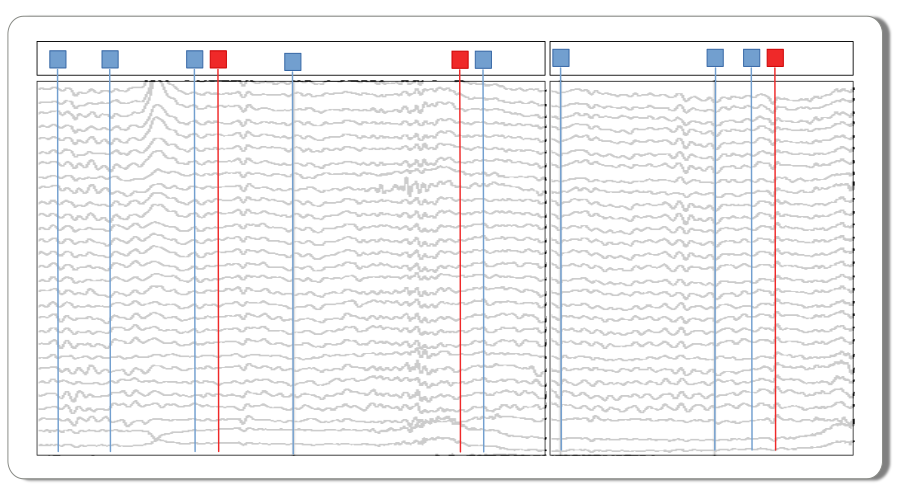

The EEG recording has already been snipped into
into 1.5 second segments and time stamped with the stimulus events at time = 0.
The experimental predictor variable data columns have been added in alignment
with the individual epochs.



In [ ]:
import pandas as pd
from fitgrid import DATA_DIR, sample_data

# download the epochs data and read into a pd.DataFrame
sample_data.get_file("sub000p3.ms1500.epochs.feather")
p3_epochs_df = pd.read_feather(DATA_DIR / "sub000p3.ms1500.epochs.feather")

**Experimental design.** These data are single-trial EEG epochs
recorded at 250 digital samples per second from one individual in an
auditory "oddball" paradigm.  The stimuli are a random sequence of
high and low pitched tones (*tone*: *hi*, *lo*) that are frequent or
infrequent (*stim*: *standard*, *target*). Stimulus trials are
presented in two blocks: the *hi* tones are the infrequent targets
in the first block and frequent standards in the second.  The task
is to respond to the infrequent tones.  In this type of paradigm,
the average potentials recorded over central and posterior scalp
after about 300 ms post-stimulus are typically more positive going
for the rare targets than for the frequent standards, a P300 ERP
effect. More information about these and other sample data may be found
at `mkpy data examples <https://eeg-workshops.github.io/mkpy_data_examples>`_.

**Data wrangling.** As with any data analysis pipeline, the epochs
data must be quality controlled and groomed to final form before
modeling. ``fitgrid`` can ingest a tidy :py:class:`pandas.DataFrame`
directly which allows for convenient data preparation with other
``pandas``-aware toolboxes and easy data interchange with other EEG
data processing platforms.  A smattering of ``pandas`` data
transforms are illustrated here.




In [ ]:
# select the experimental stimulus trials for modeling
p3_epochs_df = p3_epochs_df.query("stim in ['standard', 'target']")

# rename the time stamp column
p3_epochs_df.rename(columns={"match_time": "time_ms"}, inplace=True)

# data QC flags are set on the stimulus events, look up and select the good epochs
good_epochs = p3_epochs_df.query("time_ms == 0 and log_flags == 0")["epoch_id"]
p3_epochs_df = p3_epochs_df.query("epoch_id in @good_epochs")

# select columns of interest for modeling
indices = ["epoch_id", "time_ms"]
predictors = ["stim", "tone"]  # stim=standard, target; tone=hi, lo
channels = ["MiPf", "MiCe", "MiPa", "MiOc"]  # midline electrodes
p3_epochs_df = p3_epochs_df[indices + predictors + channels]

<div class="alert alert-info"><h4>Note</h4><p>The `epoch_id` and `time` indices must be present in the
   dataframe index (:py:class:`pandas.MultiIndex`) when loading the
   `fitgrid.Epochs` in the next step. They are also handy
   for general purpose epoch and time series data wrangling
   e.g., with :py:meth:`pandas.DataFrame.groupby` as shown here.</p></div>



In [ ]:
# set the epoch and time column index for fg.Epochs
p3_epochs_df.set_index(["epoch_id", "time_ms"], inplace=True)

# "baseline", i.e., center each epoch, each channel, on its pre-stimulus interval mean
centered = []
for epoch_id, vals in p3_epochs_df.groupby("epoch_id"):
    centered.append(
        vals[channels] - vals[channels].query("time_ms < 0").mean()
    )
p3_epochs_df[channels] = pd.concat(centered)

# done ...
p3_epochs_df

## 2. Load into :py:class:`Epochs <fitgrid.epochs.Epochs>`

The ``fitgrid`` :py:class:`Epochs <fitgrid.epochs.Epochs>` object is
a lightweight wrapper around the data that streamlines data
validation and model fitting under the hood. The epochs
data are available in the ``Epochs.table`` attribute if needed.



In [ ]:
p3_epochs_fg = fg.epochs_from_dataframe(
    p3_epochs_df,
    epoch_id="epoch_id",
    time="time_ms",
    channels=["MiPf", "MiCe", "MiPa", "MiOc"],
)
p3_epochs_fg

## 3. Fit a model

Once the ``Epochs`` are in place, the :py:meth:`fitgrid.lm
<fitgrid.models.lm>` and :py:meth:`fitgrid.lmer
<fitgrid.models.lmer>` methods sweep a model formula across the
epoch data at each time and channel and capture the model fits.  The
model formulas are those already in wide use Python and R. For
ordinary least squares (OLS) fitgrid uses :std:doc:`patsy
<patsy:index>` formulas which work like ``lm`` formulas in R when
fit with the :py:mod:`statsmodels.formula.api`. For linear
mixed-effects regression models (LME), fitgrid uses `lme4::lmer
<https://cran.r-project.org/web/packages/lme4/index.html>`_
formulas. Under the hood, the LME formulas are passed from Python to
R and the `lme4::lmer` fits returned back to Python and ``fitgrid``
via ``pymer4`` [Jolly2018]_ and
``rpy2`` [Gautier2021]_.

Here the `patsy` formula $\sim \mathsf{1 + stim}$ is used for
OLS model fitting with `statsmodels`.



In [ ]:
lmg_1_stim = fg.lm(p3_epochs_fg, RHS="1 + stim", quiet=True)

The times and channels of the :py:class:`fitgrid.Epochs <fitgrid.epochs.Epochs>`
define the :py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>` dimensions.
Each cell contains the OLS fit object. In this example, there are
375 $\times$ 4 = 1,500 fits in all.

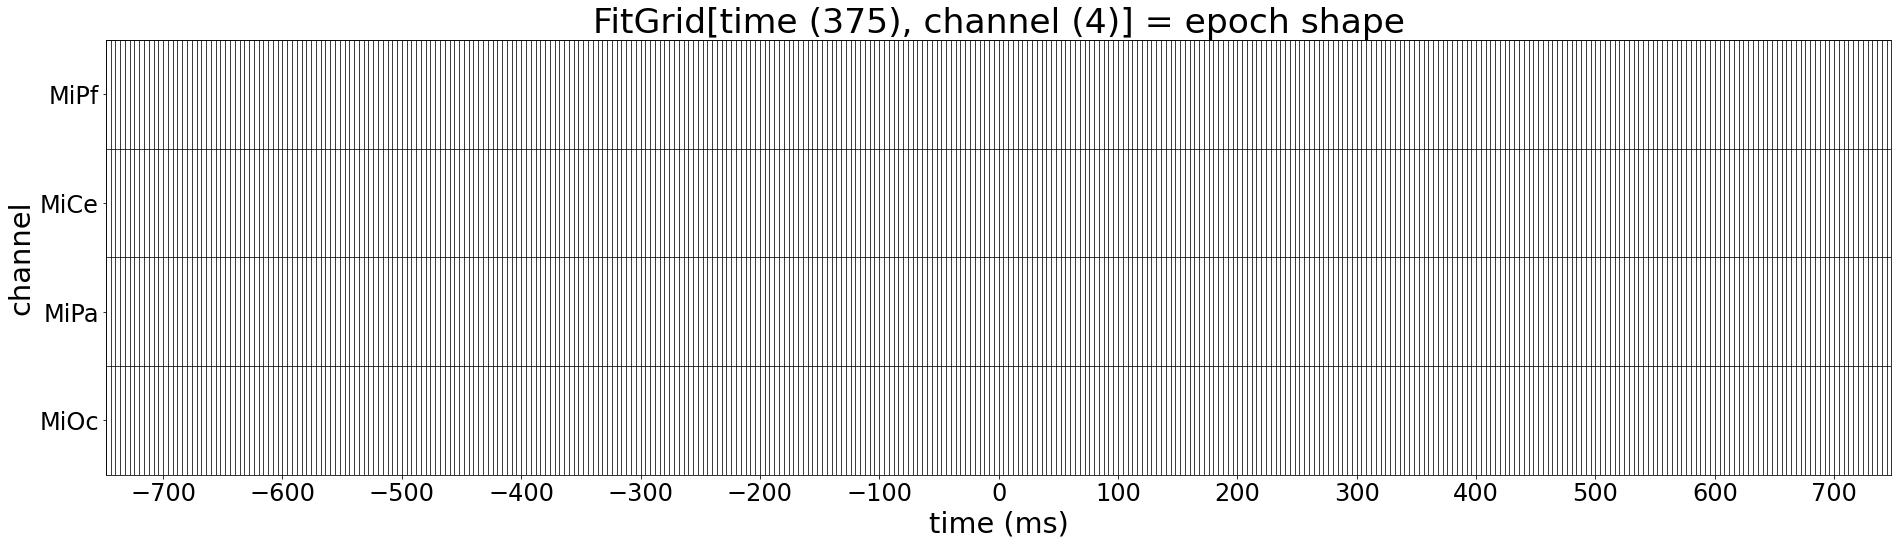



In [ ]:
lmg_1_stim

**Model formulas: good news, bad news.** The good news is
you can easily do or not do whatever you like to specify models with
the `patsy` and `lme4::lmer` formula syntax. The formulas are passed
through to the fitting algorithms and the results returned are
captured in the :py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>`.
For instance `patsy` follows
long-standing R formula behavior and includes a
constant (intercept) in the model and treatment codes categorical predictors like
$\mathsf{stim}$ by default. The alphabetically sorted first condition,
*standard* is the reference level "control", and *target* is the
"treatment. In this instance, the more compact formula $\sim
\mathsf{stim}$ is exactly equivalent $\mathsf{\sim 1 + stim}$
in the sense that they both generate the same design matrix ("right hand
side"). ``fitgrid`` doesn't care either way and will return the fits for
whatever model formula you pass in. The bad news is that you need to
know something about this kind of thing, i.e., how the user-friendly `patsy` and
`lme4::lmer` model formulas map onto the model design matrices that
are actually fit under the hood. This is generally true
for using these formula languages in any application so there is no
additional learning overhead for `fitgrid`. For OLS formulas see
N. J. Smith's excellent `patsy` documentation, `Coding categorical
data
<https://patsy.readthedocs.io/en/latest/categorical-coding.html>`_
and `How formulas work
<https://patsy.readthedocs.io/en/latest/formulas.html>`_. For
`lme4::lmer` formulas see **Section 2. Formula module** in
[BatesEtAl2015]_.




## 4. Using the :py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>`

When `statsmodels` fits an OLS model it returns a Python object
loaded with much useful information (see
:py:class:`linear_model.RegressionResults
<statsmodels.regression.linear_model.RegressionResults>`).  The same
is true of the :py:class:`Lmer <pymer4.models.Lmer>` linear
mixed-effects model fit objects returned by ``pymer4`` after running
``lme4::lmer`` in R, albeit with some differences in the terminology
and available information. The key point is that whatever
`statsmodels` knows about an OLS fit, the
:py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>` object
knows at each time and channel.

And ``statsmodels`` knows a lot:



In [ ]:
import pprint as pp

pp.pprint(dir(lmg_1_stim))

### Query fit results

In Python, the information in a single ``statsmodels`` fit object is
accessed with the usual Python ``<object>.<name>`` syntax.  The
corresponding information in the FitGrid is accessed the same
way. The results are returned in a tidy time x channel dataframe or
another :py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>`
object that makes it easy to visualize and analyze how the model fit
attributes vary over time and among the different data channels.


<div class="alert alert-danger"><h4>Warning</h4><p>Look before you leap when querying the grid. If your data set is
   large and you query the entire grid for results or model
   attributes that involve the number of observations, e.g.,
   residuals or the design matrix, you will get back dataframes or
   :py:class:`FitGrid[times, channels] <fitgrid.fitgrid.FitGrid>`
   objects at least as large as your epochs data (time x channel)
   and for more complex models with categorical variables and
   interaction effects, perhaps many times larger. If you ask
   ``fitgrid`` to do something that will swamp your computer memory,
   it will.</p></div>




**Parameter estimates** i.e., Smith & Kutas (2015) regression ERPs



In [ ]:
lmg_1_stim.params

**Parameter estimate standard errors**



In [ ]:
lmg_1_stim.bse

**Parameter** *t* **values**



In [ ]:
lmg_1_stim.tvalues

**Model log likelihood**



In [ ]:
lmg_1_stim.llf

**Model AIC**



In [ ]:
lmg_1_stim.aic

**Number of observations per grid cell** i.e., the number of epochs being modeled



In [ ]:
lmg_1_stim.nobs.astype(int)

<div class="alert alert-info"><h4>Note</h4><p>If you are using an interactive environment like Jupyter Notebook or iPython
   you can type `lmg_1_stim.` and press <TAB> to pop up a list of available attributes.</p></div>




### Slice by time and channel

The fitted grid can be sliced down to a smaller grid of times and channels using
familiar :py:class:`pandas.DataFrame` index slicing with labels and the ``:`` range
operator. As in ``pandas`` (but not Python) the range includes the upper bound.



**Parameter estimates, all times, two channels**



In [ ]:
lmg_1_stim[:, ["MiPf", "MiPa"]].params

**Log likelihood from -100 to 300 ms, all channels**



In [ ]:
lmg_1_stim[-100:300, :].llf

### Query model structure

Besides the fit results, fit objects contain model information that can be queried.
This example reaches into one cell of the ``fitgrid`` at time=0 and channel=MiPa and pulls out
the treatment coded design matrix (model right hand side) and column labels for inspection.



Here is the design matrix and its column names



In [ ]:
lmg_1_stim[0, "MiPa"].model.exog_names.unstack(-2)

In [ ]:
lmg_1_stim[0, "MiPa"].model.exog.unstack(-1)

### Visualize

The grid query dataframes are readily visualized with `matplotlib` and `pandas` or similar.
Here are simple heatmap and line plotting functions for illustration.



In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt


def heatmap_plot(grid_df, title, units=None, aspect=50, **kwargs):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(title)
    ax.set(xlabel="Time (ms)", ylabel="Channel")
    xtick_labels = range(-700, 800, 100)

    ax.set_xticks([grid_df.index.get_loc(tick) for tick in xtick_labels])
    ax.set_xticklabels(xtick_labels)

    ax.set_yticks(range(len(grid_df.columns)))
    ax.set_yticklabels(grid_df.columns)

    im = ax.imshow(grid_df.T, interpolation="none", aspect=aspect, **kwargs)
    cb = fig.colorbar(im, ax=ax)
    if units:
        cb.ax.set_title(units)
    ax.axvline(grid_df.index.get_loc(0), color='white')
    fig.tight_layout()
    return fig, ax


def line_plot(grid_df, title, units=None, **kwargs):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title(title)
    if units:
        ax.set(ylabel=units)
    grid_df.plot(ax=ax, **kwargs)
    fig.tight_layout()
    return fig, ax

**Plot parameter estimates.** The $\hat{\beta}$ over time are
regression ERPs ([SmiKut2015]_).

Note that in this model, $\beta_0 \mathbf{1} + \beta_1 X_1 + e$,
the categorical stimulus variable is treatment coded, so the
estimated intercept rERP $\hat{\beta_0}$ is the average ERP
for the frequent standard tones, i.e., the "reference" or "control"
condition. The estimated coefficient rERP
$\hat{\beta}_{\mathsf{stim[T.target]}}$ quantifies the effect
of the stimulus "treatment" relative to the "control", i.e., the
average difference ERP between the standard and target.

The parameter line plot figure shows a positive effect of about
$5 - 10 \mu\mathsf{V}$ between 300 and 400 ms over central
scalp and sustained over posterior scalp, consistent with the P300
ERP effect typical for this oddball paradigm. The heatmap shows the
same data, the positive effect appears as the brighter yellow bands.



In [ ]:
params_df = lmg_1_stim.params
bse_df = lmg_1_stim.bse

# name index columns for convenient slicing
for grid_df in [params_df, bse_df]:
    grid_df.index.set_names(["time_ms", "params"], inplace=True)

# look up the default line colors
line_colors = [prop["color"] for prop in mpl.rc_params()["axes.prop_cycle"]]

for param, vals in params_df.groupby("params"):
    vals.reset_index('params', inplace=True)
    times = vals.index.to_numpy()
    _, ax = line_plot(
        vals,
        "Model: 1 + stim\n" + r"$\hat{\beta}$ " + f"{param} (+/- 1 robust SE)",
    )
    # add SE bands
    for cdx, chan in enumerate(channels):
        lco = line_colors[cdx]
        bse = bse_df.query("params==@param")[
            chan
        ]  # look up rse this param, chan
        ax.fill_between(
            times, vals[chan] - bse, vals[chan] + bse, alpha=0.1, color=lco
        )

    ax.axhline(0, color="lightgray", lw=1, zorder=0)
    ax.axvline(0, color="gray", lw=1, zorder=1)
    ax.set(ylim=(-15, 15))
    ax.legend(loc="upper left")

In [ ]:
for param, vals in params_df.groupby("params"):
    vals.reset_index('params', drop=True, inplace=True)
    title_str = "Model: 1 + stim\n" + r"$\hat{\beta}$ " + f"{param}"
    fig, ax = heatmap_plot(vals, title_str, vmin=-9, vmax=9)

### More examples

**Query** various fit measures and parameter estimates



In [ ]:
ssr_lmg_1_stim = lmg_1_stim.ssr  # residual sum of squares
llf_1_stim = lmg_1_stim.llf  # log likelihood
aic_1_stim = lmg_1_stim.aic  # Akiake Information Criterion

params_1_stim = (
    lmg_1_stim.params
)  # estimated parameters (a.k.a. weights, coefficients, betas)
tvals_1_stim = lmg_1_stim.tvalues  # t-values
pvals_1_stim = lmg_1_stim.pvalues  # p-values
bse_lmg_1_stim = lmg_1_stim.bse  # param standard errors
rse_lmg_1_stim = (
    lmg_1_stim.HC0_se
)  # robust param standard errors (one version)

# set parameter pd.MultiIndex names for convenient slicing
for attr_df in [
    params_1_stim,
    tvals_1_stim,
    pvals_1_stim,
    bse_lmg_1_stim,
    rse_lmg_1_stim,
]:
    attr_df.index.set_names(["time_ms", "params"], inplace=True)

**Drop the predictor variable and fit the intercept only model:** $\sim \mathsf{1}$

For the intercept only model, $\beta_0 \mathbf{1} + e$, the
estimated intercept $\hat\beta_{0}$ is average ERP for all trials,
collapsed across the stimulus conditions.



In [ ]:
lmg_1 = fg.lm(p3_epochs_fg, RHS="1", quiet=True)

params_1 = lmg_1.params
params_1.index.set_names(["time_ms", "params"], inplace=True)
ssr_lmg_1 = lmg_1.ssr
llf_1 = lmg_1.llf
aic_1 = lmg_1.aic

In [ ]:
plot_chans = ["MiPf", "MiPa", "MiCe", "MiOc"]
colors = [
    prop["color"] for prop in mpl.rc_params()["axes.prop_cycle"]
]  # lookup colors

for param, vals in params_1[plot_chans].groupby("params"):
    vals.reset_index('params', inplace=True)
    times = vals.index.to_numpy()
    _, ax = line_plot(
        vals,
        "Model: ~ 1 \n" + r"$\hat{\beta}$ " + f"{param} (+/- 1 robust SE)",
    )
    # add SE
    for cdx, chan in enumerate(plot_chans):
        color = colors[cdx]

        se = rse_lmg_1_stim.query("params==@param")[chan]
        ax.fill_between(
            times, vals[chan] - se, vals[chan] + se, alpha=0.1, color=color
        )

    ax.axhline(0, color="lightgray", lw=1, zorder=0)
    ax.axvline(0, color="gray", lw=1, zorder=1)
    ax.set(ylim=(-15, 15))
    ax.legend(loc="upper left")

**Compare models full** $\sim 1 + stim$ **vs. reduced** $\sim 1$

Comparing log likelihood and AIC is useful for evaluating, diagnosing and
interpreting model fit.

The full and reduced model likelihoods heatmaps are barely distinguishable. This
is unsurprising since the stimulus variable accounts for only a small fraction of the overall
variability in the EEG.



In [ ]:
heatmap_plot(
    lmg_1_stim.llf,
    r"Log Likelihood Full Model$\mathsf{\sim 1 + stim}$",
    vmin=-1800,
    vmax=-1200,
)

heatmap_plot(
    lmg_1.llf,
    r"Log Likelihood Reduced Model$\mathsf{\sim 1}$",
    vmin=-1800,
    vmax=-1200,
)

However, the likelihood ratio (= difference of log
likelihoods) shows that the stimulus predictor does account for variability
in a way that generally aligns with the time course and channels of the post-stimulus positive
stimulus effect.




In [ ]:
title_str = r"Likelihood Ratio: Models $\frac{\mathsf{\sim 1 + stim}}{\mathsf{\sim 1}}$"
heatmap_plot(lmg_1_stim.llf - lmg_1.llf, title_str)
_, ax = line_plot(lmg_1_stim.llf - lmg_1.llf, title_str)
ax.set(ylabel="Likelihood Ratio")

For this pair-wise model comparison, AIC tells the same story as the likelihood ratio. AIC
measures may also be used to compare and evaluate larger sets of models, not just pairs, e.g.,
[BurAnd2004]_.



In [ ]:
title_str = (
    r"AIC $\Delta = AIC_{\mathsf{\sim 1}} - AIC_{\mathsf{\sim 1 + stim}}$"
)
heatmap_plot(lmg_1.aic - lmg_1_stim.aic, title_str)

_, ax = line_plot(lmg_1.aic - lmg_1_stim.aic, title_str)
ax.set(ylabel=r"AIC $\Delta$")
yticks = [-2, 0, 2, 4, 7, 10]
ax.set_yticks(yticks)
ax.hlines(
    yticks,
    xmin=times[0],
    xmax=times[-1],
    color="lightgray",
    lw=1.0,
    ls="dotted",
)

**Time domain average ERPs:** $\mathsf{\sim 0 + stim}$

Suppressing the model intercept triggers "dummy" (indicator) coded categorical predictor variables.
For this model, $\beta_0 X_0 + \beta_1 X_1 + e$, the estimated coefficients $\hat\beta_{i}$ are the
average of the trials in each condition, i.e., identical to the sum-and-divide time-domain average ERP.



In [ ]:
lmg_0_stim = fg.lm(p3_epochs_fg, RHS="0 + stim", quiet=True)
print(type(lmg_0_stim))
params_0_stim = lmg_0_stim.params
rse_0_stim = lmg_0_stim.HC0_se

for attr_df in [params_0_stim, rse_0_stim]:
    attr_df.index.set_names(["time_ms", "params"], inplace=True)

In [ ]:
plot_chans = ["MiPf", "MiPa", "MiCe", "MiOc"]
colors = [
    prop["color"] for prop in mpl.rc_params()["axes.prop_cycle"]
]  # lookup colors

# rERPs = model parameter estimates over time
for param, vals in params_0_stim[plot_chans].groupby("params"):
    vals.reset_index('params', inplace=True)
    times = vals.index.to_numpy()
    condition = param.replace("stim[", "").replace("]", "").upper()
    _, ax = line_plot(
        vals,
        "Model: ~ 0 + stim\n"
        + r"OLS $\hat{\beta}$ "
        + f"{param} = average ERP ({condition})",
    )
    # add SE
    for cdx, chan in enumerate(plot_chans):
        color = colors[cdx]
        se = rse_0_stim.query("params==@param")[chan]
        ax.fill_between(
            times, vals[chan] - se, vals[chan] + se, alpha=0.1, color=color
        )

    ax.axhline(0, color="lightgray", lw=1, zorder=0)
    ax.axvline(0, color="gray", lw=1, zorder=1)
    ax.set(ylim=(-15, 15))
    ax.legend(loc="upper left")

## 5. Next steps


### Linear mixed-effects with `lme4::lmer`

Linear mixed-effects models can be fit to epochs data with
`fitgrid.lmer` and model formulas from the `lme4::lmer` R library.
The ``fitgrid`` is populated with the `lmer` fit results and sliced
and accessed the same way as the OLS grids. The mixed-effects fits
are much slower in general so parallel processing on multicore
hardware is likely a practical necessity.

.. code-block::

   lmeg = fg.lmer(
       epochs_fg,
       RHS="1 + a + (a | subid) + (a | itemid),
       parallel=True,
       n_cores=12
   )


### Multicore parallel acceleration

A good desktop workstation may have 8 cores, a high performance compute node may have dozens or more.
With `lmer` modeling especially, it may be useful to take advantage of multiple
cores and fit models with parallel processes to speed up processing though
the performance impact depends on the system and size of the job and parallel jobs may run more slowly.

Run parallel processes by setting  ``parallel`` to  ``True`` and ``n_cores`` to the desired value (defaults to 4)
like so:

.. code-block:: python

   lmg = fg.lm(
       epochs_fg,
       RHS="1 + a + b + a:b",
       parallel=True,
       n_cores=6,
   )


<div class="alert alert-info"><h4>Note</h4><p>When working on a shared system it is rude to hog too many cores.</p></div>


### Model sets and comparisons

To reduce memory demands when fitting and comparing sets of models,
``fitgrid`` provides a convenience function `fitgrid.utils.summarize`
that iteratively fits a series of models and scrapes selected results
into lightweight summary data frame with key fit results for model
interpretation and comparison and a few helper functions for
plotting the summary results. See `guide_summaries`.


### Model and data diagnostics

When the native Python and R fit results include diagnostic
information, this can be accessed in the ``fitgrid`` like any other
attributes. In practice, however, doing so may be intractably slow
or memory intensive.  There are a few ``fitgrid`` convenience
utilities for diagnostics (see `diagnostics`) though it is an area
that needs more work.

